In [15]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from utils import *
from optimize import *
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

sns.set_style('ticks')

In [3]:
input_path = '../Data'

feature_file = 'Mordred_features_in-house.csv'
# features_file_2 =  'deepnose_features.npy'
CID_file = 'molecules_train_cid.npy'

# Read all copies, before and after correction; before was also downloaded from Dropbox.
mixture_file = 'Mixure_Definitions_Training_set.csv' 

training_task_file = 'TrainingData_mixturedist.csv'

# Dragon features
features = pd.read_csv(os.path.join(input_path, feature_file), index_col= 0)
# features_2 = np.load(os.path.join(input_path, features_file_2))

features_CIDs = np.load(os.path.join(input_path, CID_file))


# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))



In [4]:
# Print feature dimension:
print('Total # of molecules with Mordred Descriptors provided:', features.shape[0])
print('Mordred descriptor dimension:', features.shape[1])

Total # of molecules with Mordred Descriptors provided: 162
Mordred descriptor dimension: 1282


In [5]:
scaler = StandardScaler(with_mean=True, with_std=True)
features = scaler.fit_transform(features)

In [6]:
# Convert DataFrame to a numpy array
features_array = features

# Create an imputer object with mean strategy
imputer = SimpleImputer(strategy='mean')
# Impute missing values
imputed_features = imputer.fit_transform(features_array)

## Same effect here
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# imputed_features = imputer.fit_transform(features)

## Some fancy way 
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# imputer = IterativeImputer(max_iter=10, random_state=0)
# imputed_features = imputer.fit_transform(features)

In [7]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=96)
features_reduced = pca.fit_transform(imputed_features)

# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
total_variance = sum(explained_variance_ratio)
print(f"Total variance explained by 96 components: {total_variance:.2f}")

# Calculate cosine similarity before and after dimensionality reduction
cosine_sim_original = cosine_similarity(imputed_features)
cosine_sim_reduced = cosine_similarity(features_reduced)

# Calculate the average absolute difference in cosine similarity
diff_cosine_sim = abs(cosine_sim_original - cosine_sim_reduced)
avg_diff_cosine_sim = diff_cosine_sim.mean()
print(f"Average absolute difference in cosine similarity: {avg_diff_cosine_sim:.4f}")

Total variance explained by 96 components: 1.00
Average absolute difference in cosine similarity: 0.0016


In [14]:
with open('../Data/Mordred_reduced_features.npy', 'wb') as f:
    np.save(f, features_reduced)

In [9]:
# Map CID to 96 dim features:
CID2features =  {CID: features_reduced[i] for i, CID in enumerate(features_CIDs)}

In [47]:
test_mixture_unmixed_embeddings, test_CIDs = get_individual_embedding(1, "Snitz 1", mixtures_IDs, CID2features)
print('Number of molecules in this mixture:', test_mixture_unmixed_embeddings.shape[0])
print('Dimension of embedding:',  test_mixture_unmixed_embeddings.shape[1])

Number of molecules in this mixture: 10
Dimension of embedding: 96


In [48]:
X, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features, method = 'avg')

In [49]:
num_nan = np.isnan(X[0][0]).sum()
print(f"The array contains {num_nan} NaN values.")

The array contains 0 NaN values.


In [50]:
# Convert the input pairs to a suitable format for training
X_pairs = np.array([(np.concatenate((x1, x2))) for x1, x2 in X])
y_true = np.array(y)

In [51]:
X_pair1 = X_pairs[:, :96] 
X_pair2 = X_pairs[:, 96:] 

 <span style="color:orange;">NOTE: Not sure yet how to get the distance similarity etc with NaN values; we have just imputated with mean </span>

In [52]:
distances = [get_euclidean_distance(m[0], m[1]) for m in X]
similarities = [get_cosine_similarity(m[0], m[1]) for m in X]
angles = [get_cosine_angle(m[0], m[1]) for m in X] 

### Correlation between combined mixture embeddings and eperimetal values

In [53]:
dist_corr = np.corrcoef(distances, y_true)[0, 1]
print('R (Deepnose embedding Eucledian distance v.s Experimental Value): ', dist_corr)

R (Deepnose embedding Eucledian distance v.s Experimental Value):  0.3926710297379709


In [54]:
sim_corr = np.corrcoef(similarities, y_true)[0, 1]
print('R (Cosyne similarity v.s. Experimental Value): ', sim_corr)

R (Cosyne similarity v.s. Experimental Value):  -0.4719221567028916


In [55]:
angle_corr = np.corrcoef(angles, y_true)[0, 1]
print('R (Vector angle v.s. Experimental Value): ', angle_corr)

R (Vector angle v.s. Experimental Value):  0.4878145424229264


In [57]:
shared_monos = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in all_pairs_CIDs]
diff_monos = [ len( set(pair[0]).difference(set(pair[1]))) for pair in all_pairs_CIDs]

In [58]:
training_set['Eucledian Dist'] = distances
training_set['Cosyne Sim'] = similarities
training_set['Angle'] = angles
training_set['Sum num monos'] = np.array(num_mixtures).sum(axis = 1)
training_set['Shared'] = shared_monos
training_set['Diff'] = diff_monos
training_set['Num mixture1'] = np.array(num_mixtures)[:, 0]
training_set['Num mixture2'] = np.array(num_mixtures)[:, 1]

In [59]:
datasets = training_set['Dataset'].to_numpy()
encoder = OneHotEncoder()
data_arr = encoder.fit_transform(datasets.reshape(-1, 1))
data_arr = data_arr.toarray()

In [60]:
### add all information above
X_features = np.hstack((X_pairs, np.array(distances).reshape(500, 1), 
                        np.array(similarities).reshape(500, 1), 
                        np.array(angles).reshape(500, 1), 
                        np.array(shared_monos).reshape(500, 1), 
                        np.array(diff_monos).reshape(500, 1), 
                        np.array(num_mixtures), 
                        data_arr))

### First training:

In [61]:
n_folds = 10
seed = 314159

In [62]:
rf_pred_list = []
xgb_pred_list = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_features):
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]
    
    # Train the Random Forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=seed)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions 
    rf_pred = rf.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_test)
    test_indices_list.extend(test_index)  # Store the test indices

In [63]:
# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

In [64]:
# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)
training_set.head()

,Dataset,Mixture 1,Mixture 2,Experimental Values,Eucledian Dist,Cosyne Sim,Angle,Sum num monos,Shared,Diff,Num mixture1,Num mixture2,rf_pred,xgb_pred,y_true
150,Snitz 1,1,2,0.604167,12.616277,0.421956,1.135194,20,0,10,10,10,0.546275,0.551641,0.604167
300,Snitz 1,1,3,0.651042,24.032965,0.082491,1.488211,11,0,10,10,1,0.667293,0.680481,0.651042
0,Snitz 1,1,5,0.505208,11.826650,0.254107,1.313872,40,0,10,10,30,0.511260,0.494064,0.505208
1,Snitz 1,1,6,0.411458,11.836287,0.238338,1.330142,50,0,10,10,40,0.512067,0.505984,0.411458
50,Snitz 1,1,7,0.562500,21.306484,0.275216,1.291982,14,0,10,10,4,0.567210,0.530532,0.562500


In [65]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}")
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")


Random Forest - R: 0.595
Random Forest - RMSE: 0.126

XGBoost - R: 0.555
XGBoost - RMSE: 0.131


#### Observations:

1. RF although in this example has a better score, tends to predict a safe value

2. prediction are correlated for the two methods, off ones are predicted off in the same way..

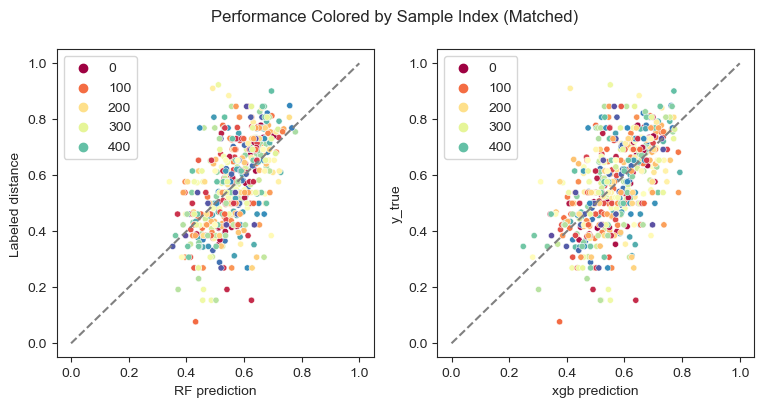

In [66]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = training_set.index, ax = ax[0], s = 20, palette= 'Spectral')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = training_set.index, ax = ax[1], s = 20, palette= 'Spectral')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Sample Index (Matched)')

plt.show()

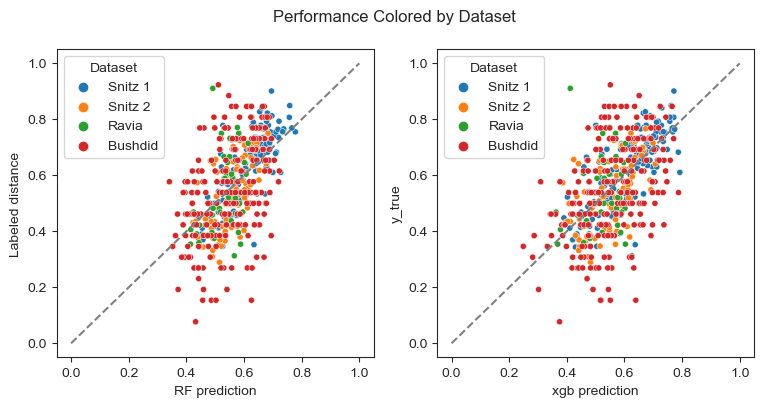

In [67]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Dataset', ax = ax[0], s = 20)
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Dataset', ax = ax[1], s = 20)
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')

fig.suptitle('Performance Colored by Dataset')
plt.show()

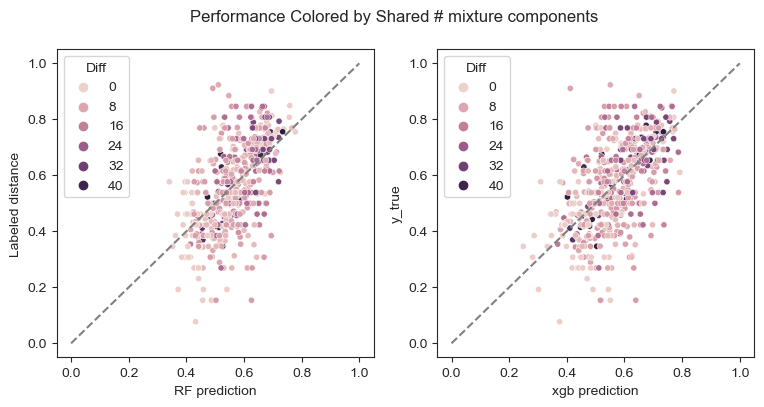

In [68]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Diff', ax = ax[0], s = 20)
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Diff', ax = ax[1], s = 20)
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')

fig.suptitle('Performance Colored by Shared # mixture components')

plt.show()

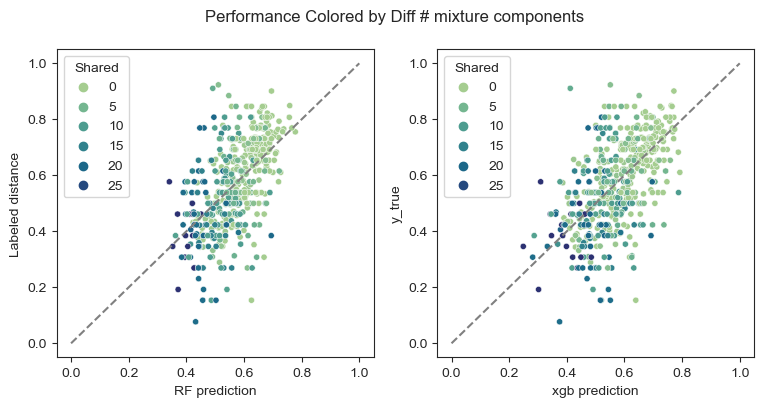

In [69]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Shared', ax = ax[0], s = 20, palette= 'crest')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Shared', ax = ax[1], s = 20, palette= 'crest')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Diff # mixture components')

plt.show()

In [70]:
training_set.groupby('Dataset')['rf_pred', 'y_true'].apply(
    lambda x: abs(x['rf_pred'] - x['y_true']).mean())

/var/folders/63/lv4_06n90jx2p5v2t58ssgwr0000gp/T/ipykernel_61811/3348153056.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  training_set.groupby('Dataset')['rf_pred', 'y_true'].apply(


Dataset
Bushdid    0.122477
Ravia      0.098065
Snitz 1    0.064694
Snitz 2    0.081616
dtype: float64

In [71]:
training_set.groupby('Dataset')['xgb_pred', 'y_true'].apply(
    lambda x: abs(x['xgb_pred'] - x['y_true']).mean())

/var/folders/63/lv4_06n90jx2p5v2t58ssgwr0000gp/T/ipykernel_61811/2246081906.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  training_set.groupby('Dataset')['xgb_pred', 'y_true'].apply(


Dataset
Bushdid    0.128129
Ravia      0.113268
Snitz 1    0.062411
Snitz 2    0.083264
dtype: float64